# Outlier and periodicity detection in K2SC

*Hannu Parviainen, University of Oxford, 2016*

This notebook outlines the outlier and periodicity detection in K2SC. The notebook uses a test set of eight light curves in `data_op` with varying characteristics.

**How to run:** evaluate the two first code cells, set the star index (`sid`), and select `Run all below` from the `Cell` menu.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import math as mt
import pyfits as pf
rc('figure', figsize=(14,6))

from glob import glob
from k2sc.k2io import MASTReader
from k2sc.ls import fasper
from k2sc.kernels import BasicKernel, BasicKernelEP, QuasiPeriodicKernel, QuasiPeriodicKernelEP
from k2sc.detrender import Detrender
from k2sc.ls import fasper
from k2sc.cdpp import cdpp

N = lambda a,b: a/nanmedian(b)

splits = [2344]
dfiles = sorted(glob('data_op/ktwo*.fits'))

## Select the star

<ol start="0">
  <li>*211436265* -- A good periodic test case with a clear 3.3 d period</li>
  <li>*211495446* -- Low variability, mostly systematics</li>
  <li>*211623711* -- Short-period variability</li>
  <li>*211696659* -- noisy periodicity</li>
  <li>*211719918* -- Very short-period variability</li>
  <li>*211779126* -- clean and simple</li>
  <li> *211841249* -- Very short-period variability</li>
  <li>*211874609* -- Very short-period variability</li>
  <li>*212029094* -- Long period variability</li>
</ol>

In [149]:
sid = 1

## 1 Initial detrending

We first do an initial detrending using a default GP hyparparameter vector. The default values have been chosen to reflect the median values of the fitted parameter vector population from campaign 4, where the fits were carried out with very loosely constraining priors.

**Note:** Here `BasicKernelEP` yields consistently a lower CDPP, and it thus is probably a better choise for the initial detrending.

130.546198438
116.174182556


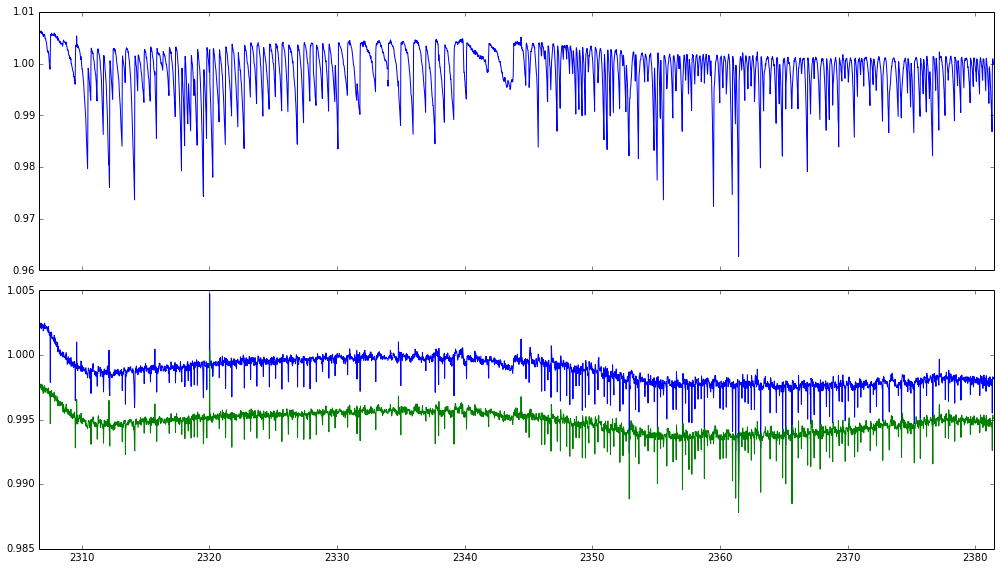

In [150]:
d  = MASTReader.read(dfiles[sid], 0)
time, flux = d.time, d.fluxes[0]
mask = isfinite(flux)

dtg = Detrender(flux, transpose([d.time,d.x,d.y]), mask=mask, splits=splits, kernel=BasicKernel())
dte = Detrender(flux, transpose([d.time,d.x,d.y]), mask=mask, splits=splits, kernel=BasicKernelEP())
ttg,tpg = dtg.predict(dtg.kernel.pv0+1e-5, components=True)
tte,tpe = dte.predict(dte.kernel.pv0+1e-5, components=True)

fig,ax = subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(time, N(flux, flux))
ax[1].plot(time, N(flux-tpg+tpg.mean(), flux))
ax[1].plot(time, N(flux-tpe+tpe.mean()-tte.ptp(), flux))
setp(ax, xlim=time[[0,-1]])
fig.tight_layout()

print cdpp(time, flux-tpg+tpg.mean())
print cdpp(time, flux-tpe+tpe.mean())

## 2 Outlier detection

Next, we do an outlier detection using basic iterative sigma-clipping.

In [161]:
map(lambda a: (nanmedian(a), a-nanmedian(a)), [[0,1,2]]) 

[(1.0, array([-1.,  0.,  1.]))]

In [151]:
tp, tt = tpe, tte
cflux  = flux-tp+median(tp)-tt+median(tt)
cflux /= nanmedian(cflux)
minf   = isfinite(cflux)
mask   = minf.copy()
nm     = None
i      = 0

while nm != mask.sum() and i<10:
    print i
    nm = mask.sum()
    mad = nanmedian(abs(cflux[mask]-nanmean(cflux[mask])))
    sigma = 1.4826*mad
    mhigh = zeros_like(minf)
    mlow  = zeros_like(minf)
    mhigh[minf] = cflux[minf] > 1+5*sigma
    mlow[minf]  = cflux[minf] < 1-5*sigma
    mask &= minf & (~mlow) & (~mhigh)
    i += 1

0
1
2


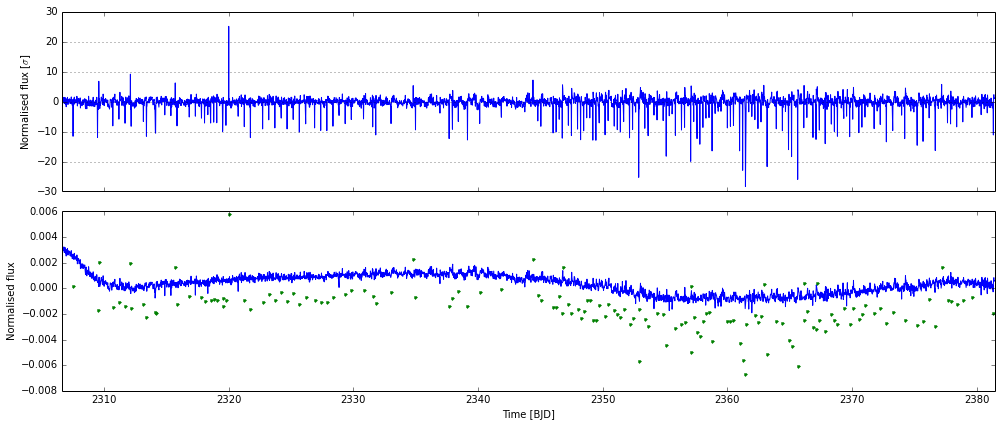

In [152]:
fig,ax = subplots(2,1, sharex=True)
ax[0].plot(time, (cflux-1)/sigma)
ax[0].grid(axis='y')
ax[1].plot(time[mask],  N(flux[mask]  - tp[mask],  flux))
ax[1].plot(time[~mask], N(flux[~mask] - tp[~mask], flux), '.')
setp(ax[0], ylabel='Normalised flux [$\sigma$]')
setp(ax[1], ylabel='Normalised flux', xlabel='Time [BJD]')
setp(ax, xlim=time[[0,-1]])
fig.tight_layout()

## 3 Period detection

We remove long time-scale trends using a 9th order polynomial fit, after which we do a Lomb-Scargle period search. The order of the polynomial was chosen to compromise between removing real long-period stellar variability and getting rid of the systematic trends, and works for all the test cases considered here.

We switch to use a quasiperiodic kernel if the false alarm probability (FAP) of the found period is lower than $10^{-50}$ (by default). However, this value can also be set as a command line argumen `--ps-min-fap`.

In [155]:
def psearch(time, flux):
    freq,power,nout,jmax,prob = fasper(time, flux, 6, 0.5)
    period = 1./freq
    m = (period > 0.05) & (period < 25) 
    period, freq, power = period[m], freq[m], power[m]
    j = argmax(power)

    expy = exp(-power)
    effm = 2.*nout/6
    fap  = expy*effm

    mfap = fap > 0.01
    fap[mfap] = 1.0-(1.0-expy[mfap])**effm
    
    return period, power, fap, j

In [153]:
nflux = flux - tp + nanmedian(tp)
ntime = time - time.mean()
p  = poly1d(polyfit(ntime[mask], nflux[mask], 9))

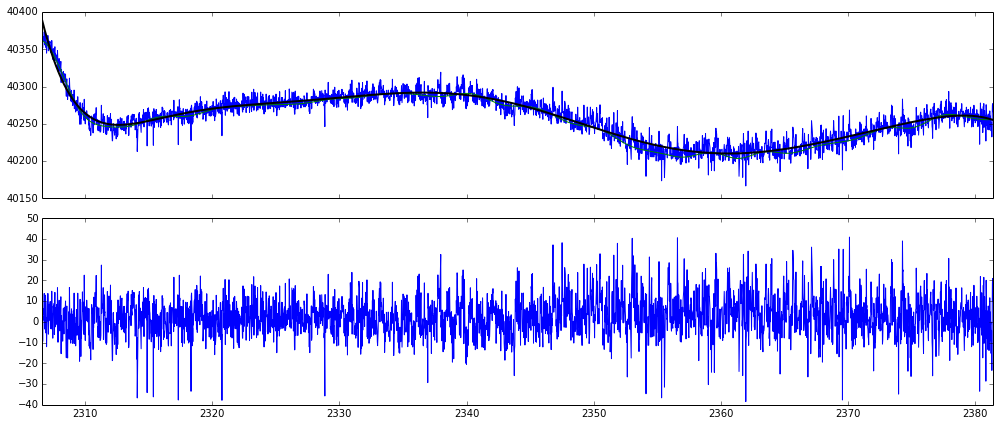

In [154]:
fig,ax = subplots(2,1, sharex=True)
ax[0].plot(time[mask], nflux[mask])
ax[0].plot(time, tt)
ax[0].plot(time, p(ntime), 'k', lw=2)
ax[1].plot(time[mask], nflux[mask]-tt[mask])
setp(ax, xlim=time[[0,-1]])
fig.tight_layout()

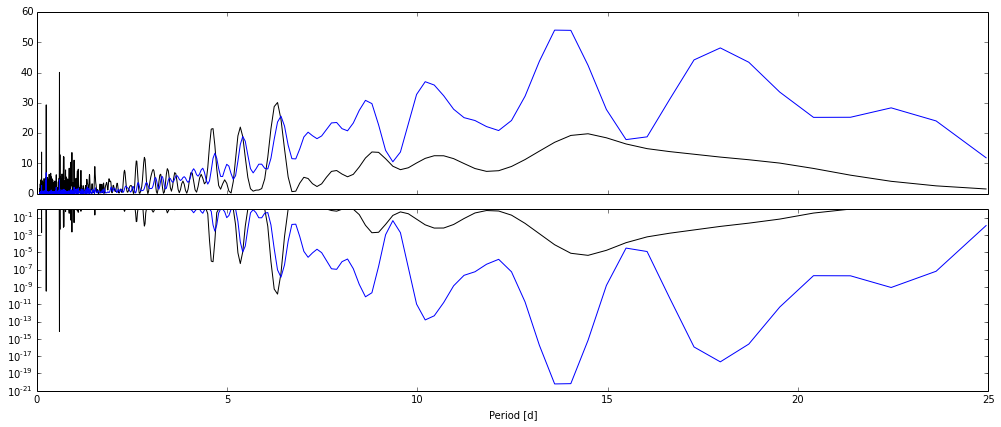

In [156]:
periodo, powero, fapo, jo = psearch(time[mask], nflux[mask])
periodp, powerp, fapp, jp = psearch(time[mask], nflux[mask]-p(ntime[mask]))
    
fig,ax = subplots(2,1, sharex=True)
ax[0].plot(periodp,powerp, 'k')
ax[0].plot(periodo,powero)
ax[1].semilogy(periodp,fapp, 'k')
ax[1].semilogy(periodo,fapo)
setp(ax, xlim=(0,25))
setp(ax[1], xlabel='Period [d]')
fig.tight_layout()

We could also do two separate searches from the detrended data and the time component. this, however, doesn't seem to be a better solution.

0.592251996584 17.9570805364


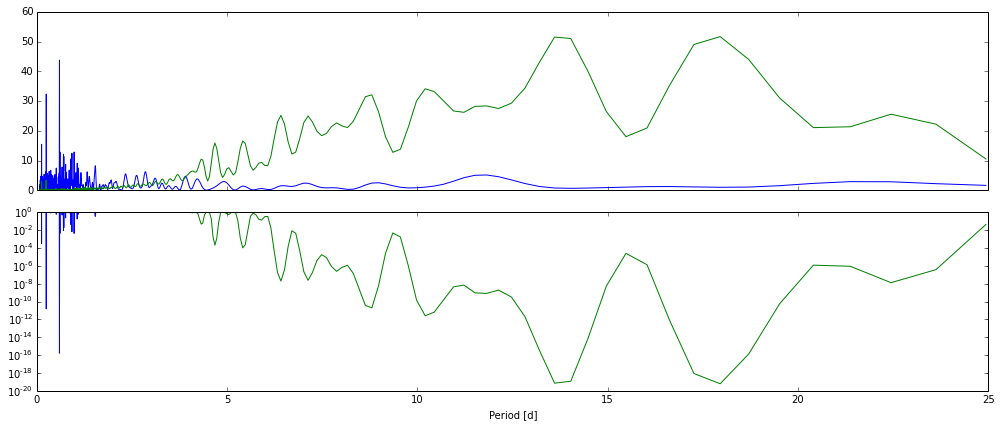

In [157]:
periods, powers, faps, js = psearch(time[mask], (nflux-tt)[mask])
periodl, powerl, fapl, jl = psearch(time[mask], tt[mask])
    
fig,ax = subplots(2,1, sharex=True)
ax[0].plot(periods,powers)
ax[0].plot(periodl,powerl)
ax[1].semilogy(periods,faps)
ax[1].semilogy(periodl,fapl)
setp(ax, xlim=(0,25))
setp(ax[1], xlabel='Period [d]')
fig.tight_layout()

print periods[js], periodl[jl]

----
<center>&copy; Hannu Parviainen, 2016</center>